In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import scale, StandardScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout

from keras.layers.normalization import BatchNormalization
from keras.initializers import Initializer
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model


In [123]:
raw_data = pd.read_csv('./data/ordered_molecules.csv')

In [124]:
x_data = raw_data.loc[(raw_data['time'] >= 0) & (raw_data['time'] <= 1998)]
target_data = raw_data.loc[(raw_data['time'] >= 1) & (raw_data['time'] <= 1999)]

In [125]:
data = pd.concat([x_data.reset_index(drop=True), target_data.iloc[:,2:].reset_index(drop=True)], axis = 1, ignore_index=True)

In [126]:
data.columns = ['time','molecule','px','py','pz','ax','ay','az','px_next','py_next','pz_next','ax_next','ay_next','az_next']

In [127]:
data['dlt_px'] = data['px_next'] - data['px']
data['dlt_py'] = data['py_next'] - data['py']
data['dlt_pz'] = data['pz_next'] - data['pz']

In [128]:
data_modi = data.drop(columns =['px','py','pz','px_next','py_next','pz_next'])

In [129]:
data_modi = data_modi[['time','molecule','ax','ay','az','dlt_px','dlt_py','dlt_pz','ax_next','ay_next','az_next']] #컬럼순서 변경

In [130]:
final_data = data_modi.loc[data_modi['time'] >= 1].reset_index(drop=True)

In [131]:
past_dlt_p = data_modi.loc[data_modi['time'] <= 1997][['dlt_px','dlt_py','dlt_pz']].reset_index(drop=True)

final_data.insert(loc = 2, column = 'past_dlt_px', value = np.array(past_dlt_p.iloc[:,0]))
final_data.insert(loc = 3, column = 'past_dlt_py', value = np.array(past_dlt_p.iloc[:,1]))
final_data.insert(loc = 4, column = 'past_dlt_pz', value = np.array(past_dlt_p.iloc[:,2]))

In [132]:
final_data.head()

,time,molecule,past_dlt_px,past_dlt_py,past_dlt_pz,ax,ay,az,dlt_px,dlt_py,dlt_pz,ax_next,ay_next,az_next
0,1,1,0.00250,-0.00074,-0.00356,1.173813,-1.541970,-4.631340,0.00257,-0.00083,-0.00379,1.161030,-1.555290,-4.646868
1,1,2,-0.00043,0.00778,-0.00325,-4.672077,-0.805457,1.064703,-0.00066,0.00771,-0.00318,-4.748614,-0.954831,1.043398
2,1,3,0.00248,0.00010,-0.00881,4.432026,-2.609304,2.213726,0.00270,-0.00004,-0.00867,4.338581,-2.607360,2.413316
3,1,4,0.00475,0.00255,0.00387,3.846336,0.828634,-2.289510,0.00495,0.00258,0.00373,3.717136,0.732364,-2.319824
4,1,5,-0.00041,-0.00127,0.00487,-1.790789,-0.845025,5.255177,-0.00050,-0.00130,0.00513,-1.717830,-0.783814,5.165356


In [133]:
exc_x_idx, = np.where(abs(final_data['dlt_px']) > 12)
exc_y_idx, = np.where(abs(final_data['dlt_py']) > 12)
exc_z_idx, = np.where(abs(final_data['dlt_pz']) > 12)

exc_past_x_idx, = np.where(abs(final_data['past_dlt_px']) > 12)
exc_past_y_idx, = np.where(abs(final_data['past_dlt_py']) > 12)
exc_past_z_idx, = np.where(abs(final_data['past_dlt_pz']) > 12)

exc_idx = set(exc_x_idx) | set(exc_y_idx) | set(exc_z_idx) | set(exc_past_x_idx) | set(exc_past_y_idx) | set(exc_past_z_idx)

final_data = final_data.loc[final_data.index.drop(list(exc_idx))].reset_index(drop=True)

In [134]:
x_train = final_data.loc[(final_data['time'] >= 0) & (final_data['time'] <= 1399)].iloc[:,2:8]
y_train = final_data.loc[(final_data['time'] >= 0) & (final_data['time'] <= 1399)].iloc[:,8:]

In [138]:
x_train.tail()

,past_dlt_px,past_dlt_py,past_dlt_pz,ax,ay,az
178598,-0.00097,-0.00994,0.00318,0.392998,4.663260,4.474376
178599,0.00244,-0.00212,-0.00579,-3.734381,5.450558,0.292773
178600,0.01217,-0.00042,-0.01265,-0.785197,-0.145187,-1.410501
178601,0.01251,0.00111,0.00350,-0.324056,2.418795,-2.570237
178602,-0.00198,-0.00060,-0.00378,0.998719,-4.024830,-2.389596


In [136]:
x_test = final_data.loc[(final_data['time'] >= 1400) & (final_data['time'] <= 1998)].iloc[:,2:8]
y_test = final_data.loc[(final_data['time'] >= 1400) & (final_data['time'] <= 1998)].iloc[:,8:]

In [139]:
x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [141]:
y_train.head()

,dlt_px,dlt_py,dlt_pz,ax_next,ay_next,az_next
0,0.00257,-0.00083,-0.00379,1.161030,-1.555290,-4.646868
1,-0.00066,0.00771,-0.00318,-4.748614,-0.954831,1.043398
2,0.00270,-0.00004,-0.00867,4.338581,-2.607360,2.413316
3,0.00495,0.00258,0.00373,3.717136,0.732364,-2.319824
4,-0.00050,-0.00130,0.00513,-1.717830,-0.783814,5.165356


In [144]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_scaler.fit(x_train)
y_scaler.fit(y_train)

#Regularization
x_train_scaled = pd.DataFrame(x_scaler.transform(x_train))
y_train_scaled = pd.DataFrame(y_scaler.transform(y_train), columns=['dlt_px','dlt_py','dlt_pz','ax_next','ay_next','az_next'])

x_test_scaled = pd.DataFrame(x_scaler.transform(x_test))
y_test_scaled = pd.DataFrame(y_scaler.transform(y_test), columns=['dlt_px','dlt_py','dlt_pz','ax_next','ay_next','az_next'])


In [148]:
#model 1
model_1 = Sequential()

model_1.add(Dense(32, input_dim=6, activation='relu', kernel_initializer = 'he_normal', kernel_regularizer = regularizers.l2(0.01)))
model_1.add(Dense(32, activation='relu', kernel_initializer = 'he_normal', kernel_regularizer = regularizers.l2(0.01)))
model_1.add(Dense(32, activation='relu', kernel_initializer = 'he_normal', kernel_regularizer = regularizers.l2(0.01)))
model_1.add(Dense(6, activation='linear', kernel_initializer = 'glorot_normal', kernel_regularizer = regularizers.l2(0.01)))

In [149]:
model_1.compile(loss='mean_squared_error', optimizer= "adam", metrics=['mse'])

early_stop = EarlyStopping(monitor='val_loss', patience=15, mode='min')
model_check_point = ModelCheckpoint('./model/DNN_dltP.h5', monitor = 'val_loss', verbose=2, save_best_only=True)
callback_list = [model_check_point, early_stop]

In [150]:
hist_1 = model_1.fit(x_train_scaled, y_train_scaled, validation_data=(x_test_scaled, y_test_scaled), epochs=150, batch_size=64, callbacks = callback_list)

Train on 178603 samples, validate on 76489 samples
Epoch 1/150
178603/178603 [==============================] - 6s 35us/step - loss: 0.4204 - mean_squared_error: 0.0371 - val_loss: 0.2518 - val_mean_squared_error: 0.0084

Epoch 00001: val_loss improved from inf to 0.25177, saving model to ./model/DNN_dltP.h5
Epoch 2/150
178603/178603 [==============================] - 6s 31us/step - loss: 0.2469 - mean_squared_error: 0.0072 - val_loss: 0.2453 - val_mean_squared_error: 0.0068

Epoch 00002: val_loss improved from 0.25177 to 0.24530, saving model to ./model/DNN_dltP.h5
Epoch 3/150
178603/178603 [==============================] - 6s 31us/step - loss: 0.2426 - mean_squared_error: 0.0063 - val_loss: 0.2421 - val_mean_squared_error: 0.0073

Epoch 00003: val_loss improved from 0.24530 to 0.24209, saving model to ./model/DNN_dltP.h5
Epoch 4/150
178603/178603 [==============================] - 6s 31us/step - loss: 0.2407 - mean_squared_error: 0.0059 - val_loss: 0.2403 - val_mean_squared_error: 0

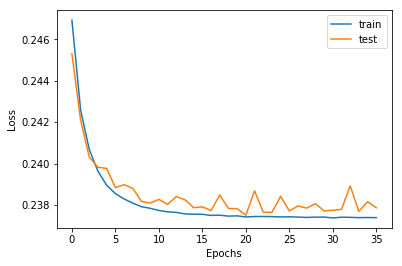

In [166]:
# plot history
plt.plot(hist_1.history['loss'][1:], label='train')
plt.plot(hist_1.history['val_loss'][1:], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [152]:
model = load_model('./model/DNN_dltP.h5')

In [159]:
y_pred = pd.DataFrame(model.predict(x_test_scaled))

y_test_inverse = pd.DataFrame(y_scaler.inverse_transform(y_test_scaled))
y_pred_inverse = pd.DataFrame(y_scaler.inverse_transform(y_pred))

In [194]:
#position error
print('rmse:', np.sqrt(mean_squared_error(y_test_inverse.iloc[:,0:3], y_pred_inverse.iloc[:,0:3])))
print('mae:', mean_absolute_error(y_test_inverse.iloc[:,0:3], y_pred_inverse.iloc[:,0:3]))
print('r2:', r2_score(y_test_inverse.iloc[:,0:3], y_pred_inverse.iloc[:,0:3]))

print('\n')
#position error
print('rmse:', np.sqrt(mean_squared_error(y_test_inverse.iloc[:,3:6], y_pred_inverse.iloc[:,3:6])))
print('mae:', mean_absolute_error(y_test_inverse.iloc[:,3:6], y_pred_inverse.iloc[:,3:6]))
print('r2:', r2_score(y_test_inverse.iloc[:,3:6], y_pred_inverse.iloc[:,3:6]))

rmse: 0.0003978273078137149
mae: 0.0003089106788016336
r2: 0.9949645992475206


rmse: 0.20404036964763334
mae: 0.14950234629018275
r2: 0.9945698056031116


In [162]:
y_test_inverse.head()

,0,1,2,3,4,5
0,0.00491,-0.00496,0.00571,-1.842484,1.326375,1.565485
1,0.01088,0.01367,-0.00474,-4.401646,-0.661288,-0.631249
2,-0.01084,0.00408,-0.00094,-2.246075,-1.475412,-0.263035
3,0.00033,-0.00828,-0.00071,0.299602,0.669824,-2.733883
4,-0.00554,0.00135,0.00060,1.311092,-2.278672,-1.748925


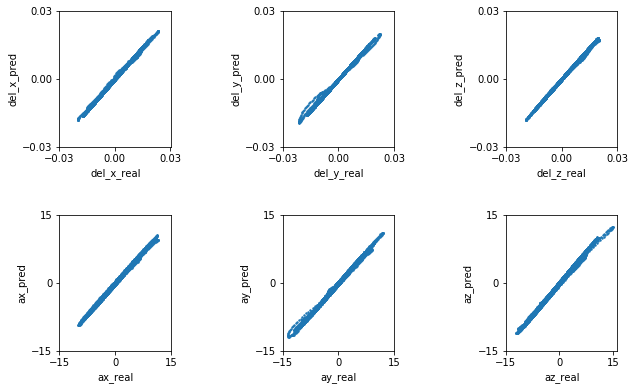

In [193]:
#Training error Check
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(3,3,1)
ax2 = fig.add_subplot(3,3,2)
ax3 = fig.add_subplot(3,3,3)
ax4 = fig.add_subplot(3,3,4)
ax5 = fig.add_subplot(3,3,5)
ax6 = fig.add_subplot(3,3,6)

ax1.scatter(y_test_inverse.iloc[:,0], y_pred_inverse.iloc[:,0], s=2)
ax1.set_xlabel('del_x_real')
ax1.set_ylabel('del_x_pred')
ax1.xaxis.set_ticks(np.arange(-0.03, 0.04, 0.03))
ax1.yaxis.set_ticks(np.arange(-0.03, 0.04, 0.03))

ax2.scatter(y_test_inverse.iloc[:,1], y_pred_inverse.iloc[:,1], s=2)
ax2.set_xlabel('del_y_real')
ax2.set_ylabel('del_y_pred')
ax2.xaxis.set_ticks(np.arange(-0.03, 0.04, 0.03))
ax2.yaxis.set_ticks(np.arange(-0.03, 0.04, 0.03))

ax3.scatter(y_test_inverse.iloc[:,2], y_pred_inverse.iloc[:,2], s=2)
ax3.set_xlabel('del_z_real')
ax3.set_ylabel('del_z_pred')
ax3.xaxis.set_ticks(np.arange(-0.03, 0.04, 0.03))
ax3.yaxis.set_ticks(np.arange(-0.03, 0.04, 0.03))

ax4.scatter(y_test_inverse.iloc[:,3], y_pred_inverse.iloc[:,3], s=2)
ax4.set_xlabel('ax_real')
ax4.set_ylabel('ax_pred')
ax4.xaxis.set_ticks(np.arange(-15, 16, 15))
ax4.yaxis.set_ticks(np.arange(-15, 16, 15))

ax5.scatter(y_test_inverse.iloc[:,4], y_pred_inverse.iloc[:,4], s=2)
ax5.set_xlabel('ay_real')
ax5.set_ylabel('ay_pred')
ax5.xaxis.set_ticks(np.arange(-15, 16, 15))
ax5.yaxis.set_ticks(np.arange(-15, 16, 15))

ax6.scatter(y_test_inverse.iloc[:,5], y_pred_inverse.iloc[:,5], s=2)
ax6.set_xlabel('az_real')
ax6.set_ylabel('az_pred')
ax6.xaxis.set_ticks(np.arange(-15, 16, 15))
ax6.yaxis.set_ticks(np.arange(-15, 16, 15))

plt.subplots_adjust(wspace = 1, hspace = 0.5)
plt.show()